## Dataset: Swedish texts published during 2021 about *COVID-19*

### Analyze Co-occurrence and Networks of of various Word ngrams


**Import Primary Libraries/Packages**

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
from matplotlib.patches import Rectangle
import itertools

In [28]:
#---NLP packages--------------------
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.util import ngrams
#----process string-------
import string
import re
from io import StringIO
import requests
#---network visualization-----------
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

In [29]:
url = "https://raw.githubusercontent.com/DimitrisKokkinakis/swedish-notebooks/refs/heads/main/textual-resources/sv_CovidCorpus2.csv"
print ('\nFile downloaded and saved!\n')

s=requests.get(url).text
# 'df' is the DataFrame containing the text data
df=pd.read_csv(StringIO(s), sep = "\t")
# Convert the date column to date format
# The column is named 'date' not 'mydate'
df["date"] = pd.to_datetime(df["date"])

print(f"The dataset consists of a total of {len(df)} posts.\n")
df.info()
print ('\nThe 100th text post/content/line of the dataset:')
df.head(5)
#["text"][100]


File downloaded and saved!

The dataset consists of a total of 2729 posts.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2729 entries, 0 to 2728
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      2729 non-null   int64         
 1   date    2729 non-null   datetime64[ns]
 2   genre   2729 non-null   object        
 3   text    2729 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 85.4+ KB

The 100th text post/content/line of the dataset:


,id,date,genre,text
0,1,2021-01-01,NEWS,Den nya virusvarianten i Storbritannien har le...
1,2,2021-01-01,NEWS,Några personer syns framför fyrverkeripjäser. ...
2,3,2021-01-01,NEWS,Under nyårsnatten bröt polisen upp en svartklu...
3,4,2021-01-01,PRDCL,Denna information kommer från boken Vad Läkeme...
4,5,2021-01-02,BLOG,Folkhälsomyndigheten försöker 'skylla' dödstal...


**Process the dataset**

In [30]:
import re
import string

def clean_text(sentence):
    if isinstance(sentence, str):  # Check if sentence is a string
        # First, replace "covid_19" with "covid-19"
        sentence = sentence.replace("covid_19", "covid-19")

        # Remove punctuation but keep underscores and hyphens within tokens
        sentence = re.sub(r"[{}]".format(re.escape(string.punctuation).replace("_", "").replace("-", "")), "", sentence.lower())

        # Replace newline and special characters
        sentence = sentence.replace('\n', ' ').replace('\r', ' ').replace('.', ' ').replace(',', ' ')\
                           .replace('?', ' ').replace('!', ' ').replace('"', ' ').replace("'", ' ')\
                           .replace('(', ' ').replace(')', ' ').replace(']', ' ').replace('/', ' ')

        # Handle hyphens: remove hyphens with spaces around them
        sentence = re.sub(r"\s-\s", " ", sentence)  # Replace " - " with a space

        # Remove extra spaces
        sentence = re.sub(r'\s+', ' ', sentence).strip()

        return sentence
    else:
        return ""  # Return empty string for non-string values

In [31]:
# Download the stopwords resource
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('swedish')

!curl -L https://raw.githubusercontent.com/DimitrisKokkinakis/swedish-notebooks/main/lexical-resources/sv_stopwords_extended.txt --output extended_stopwords.txt

# Read the Swedish / custom stop words from a text file
with open('extended_stopwords.txt', 'r') as file:
    custom_stopwords = file.read().splitlines()

# Update now the STOPWORDS set
# Use the stopwords object from nltk.corpus instead of the overwritten variable.
#nltk.corpus.stopwords.words('swedish').extend(custom_stopwords)

stopwords.extend(custom_stopwords)

print ('\nThe Swedish stop words are loaded!')
#print(f"There are a total of {len(stopwords)} stop words to be applied.")
print(f"There are a total of {len(nltk.corpus.stopwords.words('swedish'))} stop words to be applied.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


100  9830  100  9830    0     0  45051      0 --:--:-- --:--:-- --:--:-- 45091

The Swedish stop words are loaded!
There are a total of 114 stop words to be applied.


In [32]:
def get_words(sentence, stopwords):
    words = set(sentence.split(' '))
    words = list(words-set(stopwords))
    if '' in words:
        words.remove('')
    return list(words)

In [33]:
len(stopwords)

1580

**Create and Clean word list**

In [34]:
#Lower-case the whole column 'text'
df["text"] = df["text"].str.lower()

# Create a sublist of lower case words for each sample
txts = df['text'].values.tolist()
words_in_text = []
for txt in txts:
    txt = clean_text(txt)
    words_in_text.append(get_words(txt, stopwords))

**Get co-occur word pairs and Calculate word-pair frequency**

In [35]:
word_pairs = []

for words in words_in_text:
    words_ = list(set(words))
    for i in range(len(words_)-1):
        for j in range(i+1, len(words_)):
            word_i = words_[i]
            word_j = words_[j]
            if word_i < word_j:
                word_pairs.append([word_i, word_j])
            else:
                word_pairs.append([word_i, word_j])

In [36]:
df_word_pairs = pd.DataFrame(data = word_pairs, columns=['word1', 'word2'])
word_pairs_count = df_word_pairs.groupby(['word1', 'word2']).size()
word_pairs_count = word_pairs_count.sort_values().tail(200).reset_index()

In [37]:
word_pairs_count

,word1,word2,0
0,högsta,covid-19,74
1,sjukhus,pandemin,74
2,forskare,pandemin,74
3,nivåer,covid-19,75
4,coronapandemin,pandemin,75
...,...,...,...
195,covid-19,vaccin,267
196,vaccin,folkhälsomyndigheten,271
197,covid-19,pandemin,309
198,covid-19,folkhälsomyndigheten,330


In [38]:
import altair as alt #See at the end for referernce

# Rename the column '0' to 'count'
word_pairs_count = word_pairs_count.rename(columns={0: 'count'})

# Sort the DataFrame by the 'count' column in descending order and keep the top 50 rows
top_50_pairs = word_pairs_count.sort_values(by='count', ascending=False).head(50)

# Create the bar chart with increased width
bars = alt.Chart(top_50_pairs).mark_bar(size=30).encode(  # Adjust the bar size for better visibility
    x=alt.X('word1:N', axis=alt.Axis(labelAngle=-45)),    # word1 on the x-axis (nominal type) with rotated labels
    y='count:Q',                                          # count on the y-axis (quantitative type)
    color='word2:N'                                       # color the bars by word2 (nominal type)
).properties(
    width=800,                                            # Increase the width of the chart
    height=400                                            # Set a comfortable height for readability
)

# Add the text with the count value inside each bar
text = bars.mark_text(
    align='center',      # Center the text horizontally
    baseline='middle',   # Center the text vertically
    dy=-10               # Adjust the position of the text (move it slightly above the bar)
).encode(
    text='count:Q'       # Use the 'count' column as the text value
)

# Display the combined chart (bars + text)
chart = bars + text
chart.display()

#the plot shows the x strongest relationships between pairs of words
# based on their frequency or co-occurrence in some context. Each bar represents
# a pair of words, and the height of the bar shows how strong their relationship
#is — the higher the bar, the stronger the relationship.

alt.LayerChart(...)

**Bigrams: a pair of consecutive written words**

In [39]:
import itertools
import collections # import the collections module

# Create list of lists containing bigrams
terms_bigram = [list(bigrams(words)) for words in words_in_text]

# View bigrams for the first assay
print('View bigrams for the first assay')
print(terms_bigram[0][:5])

# Flatten list of bigrams in clean text
bigram_list = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigram_list)

bigram_counts.most_common(5)

View bigrams for the first assay
[('ljusna', 'gränsen'), ('gränsen', 'bergström'), ('bergström', 'virusvåg'), ('virusvåg', 'smittsamhet'), ('smittsamhet', 'höst')]


[(('covid-19', 'meddelade'), 69),
 (('fortsatt', 'vaccin'), 56),
 (('vaccin', 'doser'), 55),
 (('vaccinet', 'covid-19'), 49),
 (('covid-19', 'vaccination'), 49)]

**n-grams (n=3)**

In [40]:
# Create list of lists containing bigrams
terms_3gram = [list(ngrams(words, 3)) for words in words_in_text]

# View bigrams for the first assay
print('View N-grams (N=3) for the first assay')
print(terms_3gram[0][:5])

gram3_list = list(itertools.chain(*terms_3gram))

# Create counter of words in clean bigrams
gram3_counts = collections.Counter(gram3_list)

gram3_counts.most_common(5)

View N-grams (N=3) for the first assay
[('ljusna', 'gränsen', 'bergström'), ('gränsen', 'bergström', 'virusvåg'), ('bergström', 'virusvåg', 'smittsamhet'), ('virusvåg', 'smittsamhet', 'höst'), ('smittsamhet', 'höst', 'avundsjuka')]


[(('eu', 'vaccin', 'doser'), 10),
 (('skydd', 'vaccin', 'delta'), 8),
 (('vaccination', 'vaccinationer', 'regionen'), 7),
 (('folkhälsomyndigheten', 'rekommendationer', 'smittspridningen'), 7),
 (('covid-19', 'sjukhusvård', 'sjukhus'), 7)]

**Visualize Networks of Bigrams and Co-occur Pairs**

In [41]:
# Create network plot
G = nx.Graph()

for _, row in word_pairs_count.iterrows():
   # G.add_edge(row['word1'], row['word2'], weight=row[0])
    G.add_edge(row['word1'], row['word2'], weight=float(row[2]))

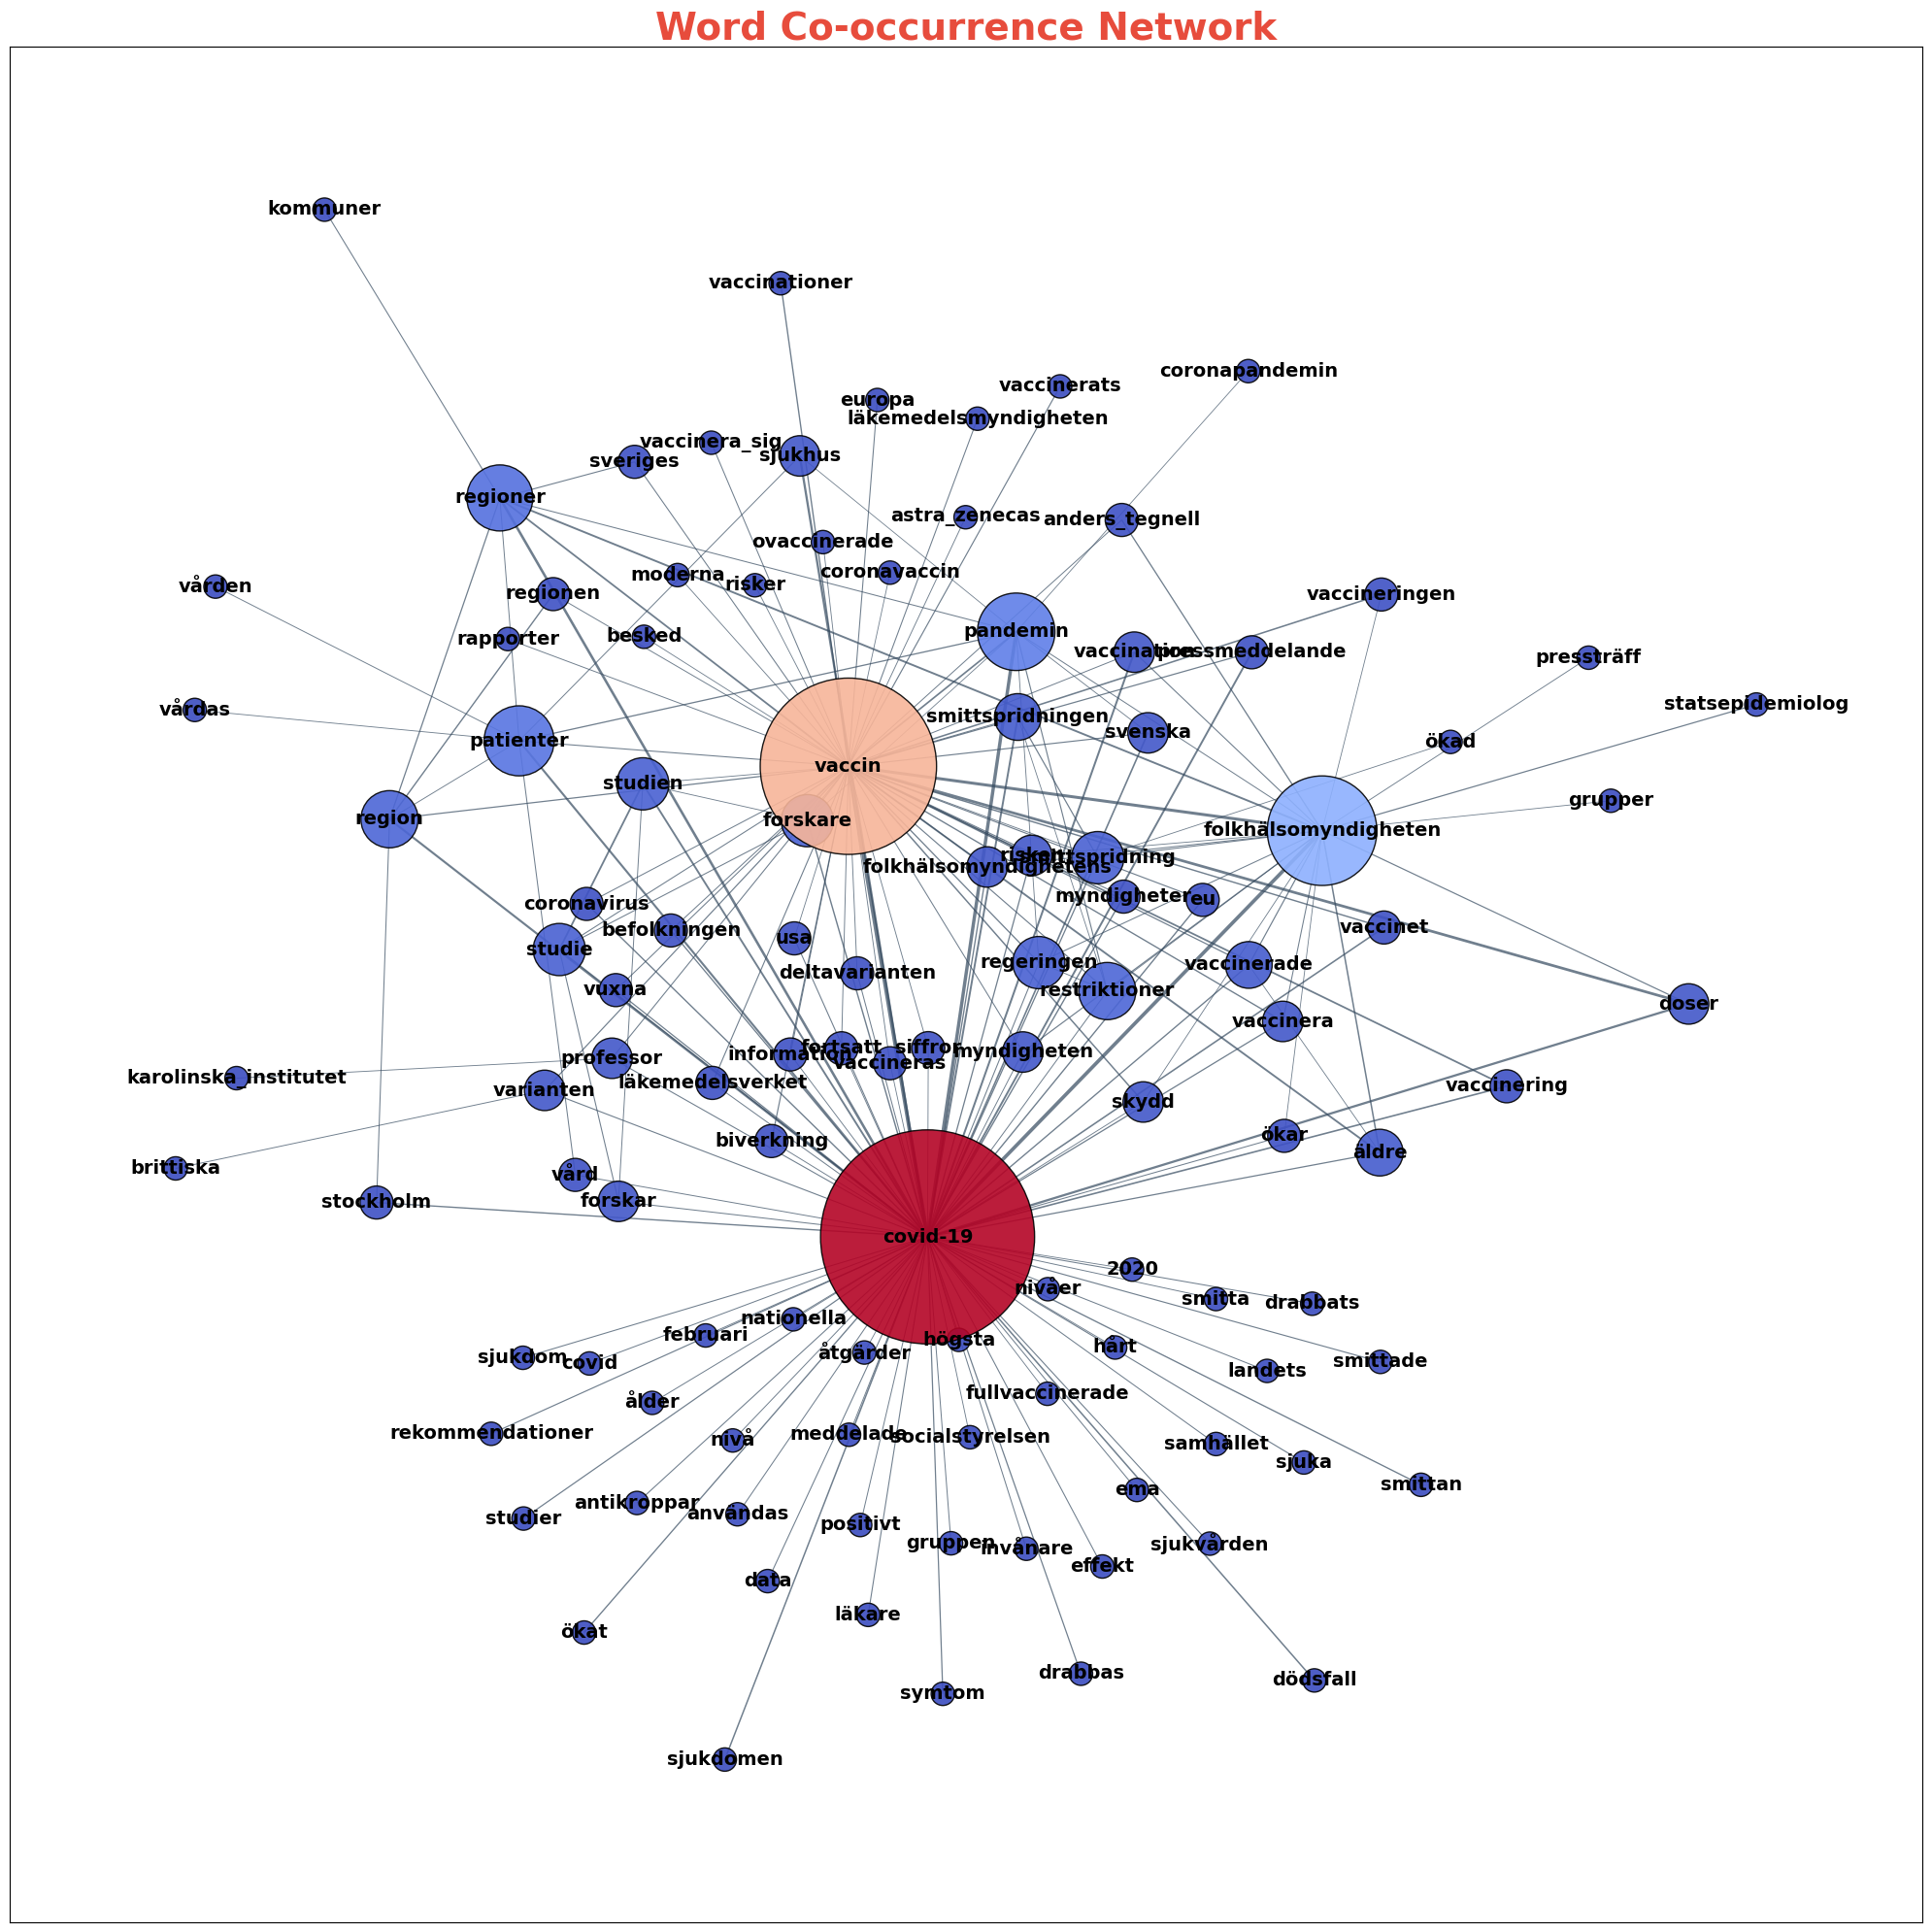

In [42]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Generate a layout for the nodes
#pos_kkl = nx.kamada_kawai_layout(G)
pos_kkl = nx.kamada_kawai_layout(G, weight='weight')

# Create figure and axis with larger size to accommodate bigger nodes
f, ax = plt.subplots(figsize=(20, 20))

# Node degree dict (for node sizes)
d = dict(nx.degree(G))

# Extract edge weights and rescale them
edges = G.edges()
weights = [G[u][v]['weight'] / 1000 for u, v in edges]

# Draw the network
node_colors = [v for v in d.values()]  # Color nodes by degree or any other property
edge_colors = ['#34495e' if G[u][v]['weight'] > 1 else '#95a5a6' for u, v in edges]  # Example: bold darker edges for heavier weights

# Increase node size (larger than before) and set edge color
nodes = nx.draw_networkx_nodes(G, pos_kkl,
                               node_size=[v * 300 for v in d.values()],  # Increase node size scaling factor
                               nodelist=d.keys(),
                               node_color=node_colors,
                               cmap="coolwarm",
                               alpha=0.9,
                               edgecolors="black")  # Black edges around nodes

# Draw thicker edges with increased width
edges = nx.draw_networkx_edges(G, pos_kkl,
                               edgelist=edges,
                               width=[w * 8 for w in weights],  # Increase edge width
                               edge_color=edge_colors,
                               alpha=0.7)

# Draw node labels
nx.draw_networkx_labels(G, pos_kkl,
                        font_size=14,  # Slightly larger font for better readability
                        font_color="black",
                        font_weight="bold")

# Set title with more vibrant styling
ax.set_title('Word Co-occurrence Network',
             fontdict={'fontsize': 28,
                       'fontweight': 'bold',
                       'color': '#e74c3c',
                       'verticalalignment': 'baseline',
                       'horizontalalignment': 'center'},
             loc='center')

# Enhance layout and aesthetics
plt.tight_layout()

# Set border color for nodes (optional, depends on preference)
plt.gca().collections[0].set_edgecolor("#000000")

plt.show()

In [43]:
# Create network plot
G = nx.Graph()

# Create connections between nodes
for v in bigram_counts.most_common(30):
    G.add_edge(v[0][0], v[0][1], weight=(v[1] * 10))

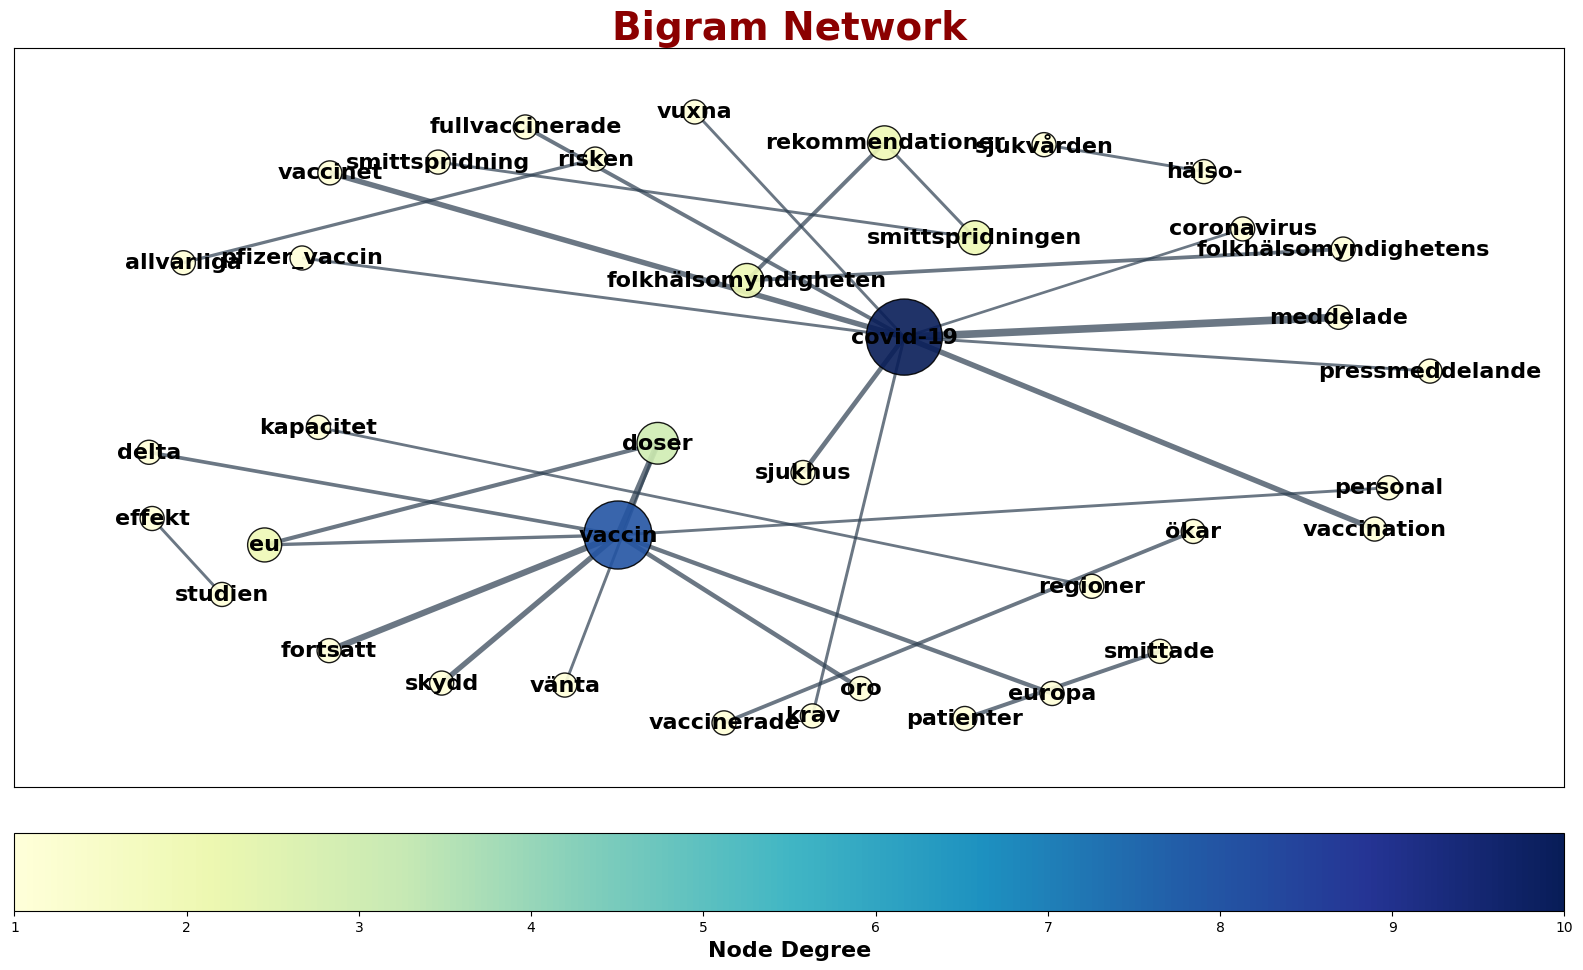

In [44]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Create the plot with a larger figure size for better layout
fig, ax = plt.subplots(figsize=(20, 12))

# Use spring layout with increased distance between nodes
pos = nx.spring_layout(G, k=8, seed=42)  # Set a random seed for reproducibility

# Node degree dict (for node sizes and coloring)
d = dict(nx.degree(G))

# Extract edge weights and rescale them for visualization
edges = G.edges()
weights = [G[u][v]['weight'] / 1000 for u, v in edges]

# Node color based on degree (you can use another property if needed)
node_colors = [v for v in d.values()]  # Color nodes by degree or other property

# Use a lighter colormap for nodes, such as "cividis" or "YlGnBu"
lighter_cmap = plt.cm.YlGnBu  # This will produce lighter colors

# Edge color (darker for heavier weights)
edge_colors = ['#2c3e50' if G[u][v]['weight'] > 1 else '#7f8c8d' for u, v in edges]

# Draw the nodes with a lighter colormap, larger size, and black edges for visibility
nodes = nx.draw_networkx_nodes(G, pos,
                               node_size=[v * 300 for v in d.values()],  # Increase node size scaling
                               node_color=node_colors,
                               cmap=lighter_cmap,  # Use a lighter colormap for better label visibility
                               edgecolors="black",  # Black edges around nodes
                               alpha=0.9)

# Draw edges with bold lines and varying thickness
edges = nx.draw_networkx_edges(G, pos,
                               edgelist=edges,
                               width=[w * 8 for w in weights],  # Thicker edges
                               edge_color=edge_colors,
                               alpha=0.7)

# Draw node labels with bold font
nx.draw_networkx_labels(G, pos,
                        font_size=16,
                        font_color="black",  # Keep the labels black for high contrast
                        font_weight="bold")

# Set title with improved font styling
ax.set_title('Bigram Network',
             fontdict={'fontsize': 28,
                       'fontweight': 'bold',
                       'color': 'darkred',
                       'verticalalignment': 'baseline',
                       'horizontalalignment': 'center'},
             loc='center')

# Set a color bar for the node colormap and place it below the plot
sm = plt.cm.ScalarMappable(cmap=lighter_cmap,
                           norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm.set_array([])

# Position the color bar below the plot
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05)  # pad adjusts the space between plot and color bar
cbar.set_label('Node Degree', fontsize=16, weight='bold')

# Apply tight layout for better spacing
#plt.tight_layout()

# Display the plot
plt.show()

In [45]:
stop_words = stopwords
len(stop_words)

1580

In [46]:
#a graph for asingle word!
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
import re
import requests
from io import StringIO
import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('swedish')

# Read the Swedish / custom stop words from a text file
with open('extended_stopwords.txt', 'r') as file:
    custom_stopwords = file.read().splitlines()

# Load the CSV file with text data (replace 'your_file.csv' with your actual file)
url = "https://raw.githubusercontent.com/DimitrisKokkinakis/swedish-notebooks/refs/heads/main/textual-resources/sv_CovidCorpus2.csv"


s=requests.get(url).text
# 'df' is the DataFrame containing the text data
df=pd.read_csv(StringIO(s), sep = "\t")
# Convert the date column to date format

!curl -L https://raw.githubusercontent.com/DimitrisKokkinakis/swedish-notebooks/main/lexical-resources/sv_stopwords_extended.txt --output extended_stopwords.txt

# Preprocess text: lowercase, remove punctuation, tokenize, and remove stopwords
def preprocess_text(text):
    #stop_words = stopwords.extend(custom_stopwords)
    stop_words = stopwords.copy() # Create a copy of stopwords
    stop_words.extend(custom_stopwords) # Extend the copy with custom stopwords
    # Lowercase and remove punctuation
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    # Tokenize and remove stopwords
    tokens = [word for word in text.split() if word not in stop_words]
    return tokens

# Create a function to get word co-occurrences
def get_word_associations(tokens, window_size=2, target_words=None):
    co_occurrences = Counter()
    if target_words is None:
        target_words = []
    for i in range(len(tokens) - window_size + 1):
        window = tokens[i:i + window_size]
        pairs = combinations(window, 2)
        # Only count pairs with at least one target word if specified
        if any(word in window for word in target_words):
            co_occurrences.update(pairs)
    return co_occurrences

# Build the graph from word associations
def build_graph(word_associations, target_words, top_n=25, min_weight=1):
    G = nx.Graph()

    # Filter for the 25 most common associated words per target word
    filtered_associations = {pair: weight for pair, weight in word_associations.items()
                             if any(word in pair for word in target_words)}

    # Select the 20 most common associations for each target word
    top_associations = []
    for word in target_words:
        associated_words = [(pair, weight) for pair, weight in filtered_associations.items() if word in pair]
        top_associations.extend(sorted(associated_words, key=lambda x: x[1], reverse=True)[:top_n])

    # Add top associations to the graph
    for (word1, word2), weight in top_associations:
        if weight >= min_weight:
            G.add_edge(word1, word2, weight=weight)

    return G

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9830  100  9830    0     0   119k      0 --:--:-- --:--:-- --:--:--  119k


In [47]:
# Function to visualize the graph with enhanced aesthetics
def visualize_graph(G, target_words):
    pos = nx.spring_layout(G, k=0.5, seed=42)  # Better layout to space nodes, `k` controls the distance between nodes
    plt.figure(figsize=(12, 12))

    # Draw the nodes with different sizes and colors based on target words
    node_sizes = [3000 if node in target_words else 1200 for node in G.nodes()]
    node_colors = ['#FF6347' if node in target_words else '#87CEEB' for node in G.nodes()]

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9, linewidths=2)

    # Draw edges with variable thickness based on weight
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=[weight * 0.5 for weight in edge_weights], alpha=0.6)

    # Draw labels with larger font size
    nx.draw_networkx_labels(G, pos, font_size=14, font_color='black', font_weight='bold')

    # Add edge labels (optional) to display the weights
    edge_labels = {(u, v): f'{G[u][v]["weight"]}' for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, label_pos=0.5, alpha=0.7)

    # Remove axis
    plt.axis('off')
    plt.show()

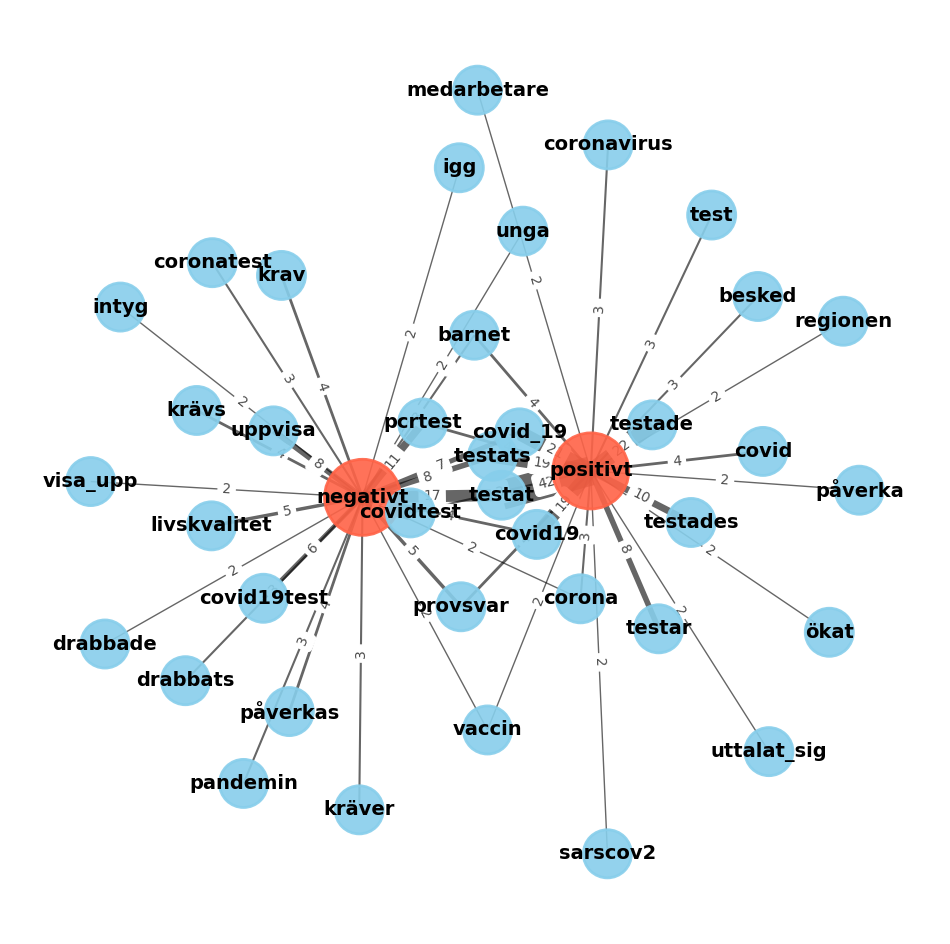

In [48]:
# Main flow: Read CSV, preprocess, and build the graph
# Assuming the text data is in a column called 'text'
all_text = " ".join(df['text'].dropna())  # Combine all text data into one string
tokens = preprocess_text(all_text)

# Target words (words of interest)
#target_words = ['intyg', 'covidtest']
#target_words = ['sommar','vinter']
target_words = ['negativt','positivt']
#target_words = ['mutation','antikroppar']
#target_words = ['norge','danmark']
#target_words = ['männen','kvinnorna']

# Get word associations for the target words
word_associations = get_word_associations(tokens, window_size=2, target_words=target_words)

# Build the network graph based on associations, keeping only the top 25 associations per target word
G = build_graph(word_associations, target_words, top_n=25, min_weight=2)

# Visualize the network with enhanced aesthetics
visualize_graph(G, target_words)

altair: https://doi.org/10.21105/joss.01057

https://www.kaggle.com/code/xxxxyyyy80008/analyze-co-occurrence-and-networks-of-words

https://github.com/yashasvi14/Keyword-Network-and-Word-Frequency-analysis/blob/main/code.ipynb

https://colab.research.google.com/github/aeturrell/coding-for-economists/blob/main/text-nlp.ipynb

<good> https://github.com/SokKanaTorajd/gemastik21/blob/main/Text-Network-Analysis-Cryptocurrency-in-Indonesia.ipynb